In [1]:
%matplotlib notebook
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import json
import glob
import cv2

seed = 3 # debug!!!
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [2]:
if not os.path.exists('./previews'):
    os.makedirs('./previews')
if not os.path.exists('./checkpoints'):
    os.makedirs('./checkpoints')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
n_row, n_col, n_ch = 32, 32, 1
n_feature = 100
g_feature_map_b = 64
d_feature_map_b = 64

In [3]:
def one_hot(x, n_class):
    ohe = np.zeros((len(x), n_class), dtype=np.uint8)
    ohe[np.arange(len(x)), x] = 1
    return ohe

torch.Size([1, 32, 32])


<IPython.core.display.Javascript object>


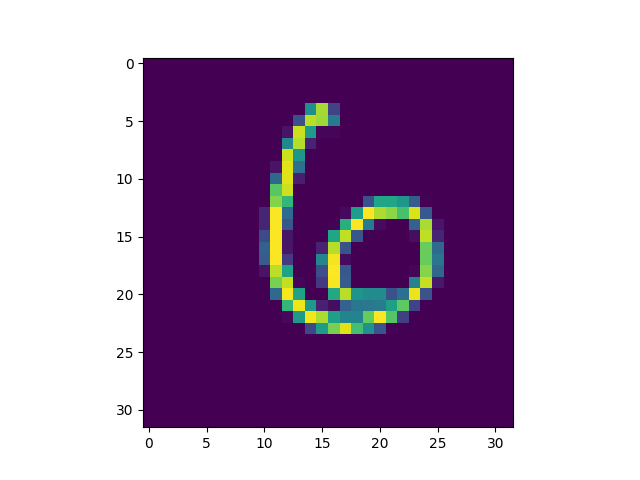

In [4]:
'''
fold_dataset = datasets.ImageFolder('./pixiv_face_tagged', 
                       transform=transforms.Compose([
                           transforms.RandomHorizontalFlip(),
                           transforms.RandomAffine(5, translate=(0.05,0.05), scale=(0.9,1.1), shear=2, resample=2, fillcolor=tuple([127]*n_ch)),
                           transforms.Resize([n_dim]*2, interpolation=2),
                           transforms.ToTensor(), # normalize to [0,1]
                           transforms.Normalize([0.5]*n_ch, [0.5]*n_ch) # [0,1] -> [-1,+1]
                       ]))
'''
fold_dataset = datasets.MNIST('./mnist_data', download=True, train=False, transform=transforms.Compose([
                           transforms.Pad(2), # 28 -> 32
                           transforms.ToTensor(), # normalize to [0,1]
                           transforms.Normalize([0.5]*n_ch, [0.5]*n_ch) # [0,1] -> [-1,+1]
                       ]))

print(fold_dataset.__getitem__(100)[0].shape)
plt.imshow(np.squeeze(np.clip(np.array(fold_dataset.__getitem__(100)[0]).transpose(1,2,0)*127.5+127.5,0,255).astype(np.uint8)))
plt.show()
data_loader = torch.utils.data.DataLoader(
        fold_dataset,
        batch_size=batch_size, shuffle=True, num_workers=4)
def inf_data_gen():
    while True:
        for data, label in data_loader:
            yield data
gen = inf_data_gen()

In [5]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0, 0.001)
    elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0, 0.001)

class ConvolutioBlock(nn.Module):
    def __init__(self, in_ch, out_ch, norm=True, down=False, relu=True, leaky=False, dropout=False):
        super(ConvolutioBlock, self).__init__()
        
        conv_block = []
        conv_block += [nn.Conv2d(in_ch, out_ch, 3, stride=2 if down else 1, padding=1, bias=False)]
        if norm:
            conv_block += [nn.InstanceNorm2d(out_ch)]
        if relu:
            conv_block += [ nn.LeakyReLU(0.2, inplace=True) if leaky else nn.ReLU(inplace=True) ]
        if dropout:
            conv_block += [nn.Dropout(0.05)]

        self.conv_block = nn.Sequential(*conv_block)
        self.conv_block.apply(weights_init)
    def forward(self, x):
        return self.conv_block(x)

# ref SRResNet
class ResidualBlock(nn.Module):
    def __init__(self, in_ch):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.Conv2d(in_ch, in_ch, 3, stride=1, padding=1, bias=False),
                        nn.InstanceNorm2d(in_ch),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(in_ch, in_ch, 3, stride=1, padding=1, bias=False),
                        nn.InstanceNorm2d(in_ch)  
                     ]

        self.conv_block = nn.Sequential(*conv_block)
        self.conv_block.apply(weights_init)

    def forward(self, x):
        return x + self.conv_block(x)

class UpConvolution(nn.Module):
    def __init__(self, in_ch, out_ch, norm=True, relu=True):
        super(UpConvolution, self).__init__()
        
        conv_block = [nn.PixelShuffle(2)]
        conv_block += [nn.Conv2d(in_ch//4, out_ch, 3, stride=1, padding=1, bias=False)]
        if norm:
            conv_block += [nn.InstanceNorm2d(out_ch)]
        if relu:
            conv_block += [nn.ReLU(inplace=True)]

        self.conv_block = nn.Sequential(*conv_block)
        self.conv_block.apply(weights_init)

    def forward(self, x):
        return self.conv_block(x)

class C(nn.Module):
    def __init__(self, N_ROW=32, N_COL=32, N_CH=3, BASE_FEATURE_N=32):
        super(C, self).__init__()
        self.n_row = N_ROW
        self.n_col = N_COL
        self.n_ch = N_CH
        self.base_f = BASE_FEATURE_N
        self.head_conv = nn.Conv2d(self.n_ch, self.base_f, 3, stride=1, padding=1, bias=False)
        weights_init(self.head_conv)
        self.convs = nn.Sequential(*[
            ConvolutioBlock( self.base_f, self.base_f,   norm=True, down=True, relu=True, leaky=True, dropout=True ),
            ConvolutioBlock( self.base_f, self.base_f*2, norm=True, down=True, relu=True, leaky=True, dropout=True ),
            ConvolutioBlock( self.base_f*2, self.base_f*4, norm=True, down=True, relu=True, leaky=True, dropout=True ),
            #ConvolutioBlock( self.base_f*4, self.base_f*8, norm=True, down=True, relu=True, leaky=True, dropout=True ),
        ])
        self.tail_conv = nn.Conv2d(self.base_f*4, 1, (self.n_row//8, self.n_col//8), stride=1, padding=0, bias=False)
        weights_init(self.tail_conv)
        
    def forward(self, x):
        
        x = self.head_conv(x)
        
        x = self.convs(x)
        
        x = self.tail_conv (x)
        x = x.view(x.size(0), 1) 
        return x

class G(nn.Module):
    def __init__(self, N_ROW, N_COL, N_FEATURE, N_CH, BASE_FEATURE_N=32):
        super(G, self).__init__()
        self.n_row = N_ROW
        self.n_col = N_COL
        self.n_ch  = N_CH
        self.base_f = BASE_FEATURE_N
        self.n_feature = N_FEATURE
        self.latent_map = nn.Linear(self.n_feature, self.base_f*8*((self.n_row//16)*(self.n_col//16))) 
        weights_init(self.latent_map)
        self.convs = nn.Sequential(*[
            UpConvolution(self.base_f*8, self.base_f*4, norm=True, relu=True), # 2x
            UpConvolution(self.base_f*4, self.base_f*2, norm=True, relu=True), # 8x
            UpConvolution(self.base_f*2, self.base_f*2, norm=True, relu=True), # 16x
            UpConvolution(self.base_f*2, self.base_f, norm=True, relu=True),   # 32x
        ])
        self.tail_conv = nn.Conv2d(self.base_f, self.n_ch, 3, stride=1, padding=1, bias=False)
        weights_init(self.tail_conv)
        
    def forward(self, x):
        x = self.latent_map(x)
        x = x.view(x.size(0), self.base_f*8, self.n_row//16, self.n_col//16)
        x = self.convs(x)
        x = self.tail_conv (x)
        x = torch.tanh(x)
        return x

In [6]:
def plot2dir(directory='./previews', imgs=None, iter_n=0):
    imgs = np.clip(np.round((np.concatenate(tuple(imgs.transpose(0,2,3,1)), axis=0)+1)*127.5), 0, 255).astype(np.uint8) # (?, 28, 28)
    cv2.imwrite('{}/{:08d}.jpg'.format(directory, iter_n), np.squeeze(imgs[...,::-1])) # RGB->BGR

In [7]:
G_net = G(n_row, n_col, n_feature, n_ch, g_feature_map_b).to(device)
C_net = C(n_row, n_col, n_ch, d_feature_map_b).to(device)
opt_C = optim.Adam(C_net.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_G = optim.Adam(G_net.parameters(), lr=0.0002, betas=(0.5, 0.999))

<IPython.core.display.Javascript object>


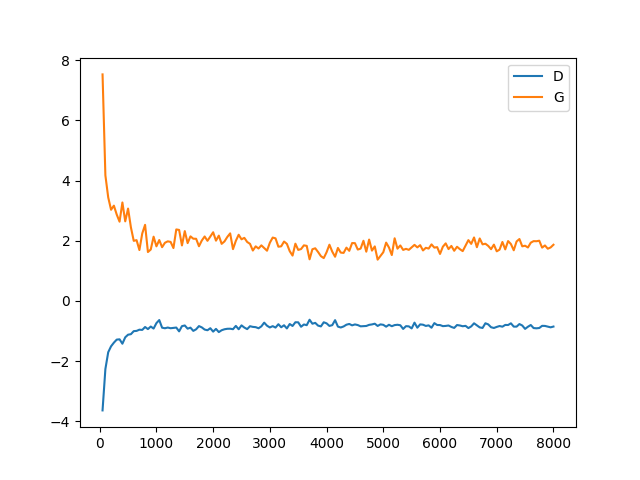

In [8]:
from tqdm import tqdm_notebook

iterations = 8000
preview_iter = 500
plot_iter = 50
preview_n = 8
d_iter = 2
std = 1.0
beta = 0.001

samples_preview = []
for c in range(preview_n):
    samples_preview.append(torch.randn(preview_n, n_feature).clamp(-3,3) * std)

ites = []
G_list = []
D_list = []

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

tqdm_ite = tqdm_notebook(range(1, iterations+1))

for ite in tqdm_ite:
    # train D:
    G_net.eval()
    C_net.train()
    d_loss_mean = 0.0
    g_loss_mean = 0.0
    for _ in range(d_iter):
        opt_C.zero_grad()
        real = next(gen)
        real = real.to(device)
        with torch.no_grad():
            sample = torch.randn(real.size(0), n_feature, device=device).clamp(-3,3) * std
            fake   = G_net(sample).detach() # not to touch G_net
        d_real = C_net(real)
        d_fake = C_net(fake)
        
        d_loss = d_real - d_fake
        d_norm = 10 * (real - fake).abs().mean()
        d_loss = -d_loss + 0.5 * d_loss**2 / d_norm
        d_loss = d_loss.mean()
        d_loss.backward()
        
        opt_C.step()
        d_loss_mean += d_loss.item()
    d_loss_mean /= d_iter
    # train G:
    G_net.train()
    C_net.eval() 
    real = next(gen)
    real = real.to(device)
    opt_G.zero_grad()
    sample = torch.randn(real.size(0), n_feature, device=device).clamp(-3,3) * std
    generated = G_net(sample)
    g_loss = (C_net(real) - C_net(generated)).mean() + beta * torch.abs(real-generated).mean()
    g_loss.backward()
    opt_G.step()
    g_loss_mean = g_loss.mean().item()
    if ite%plot_iter==0:
        tqdm_ite.set_description('G:{:.4f}, D:{:.4f}'.format(g_loss_mean, d_loss_mean))
        tqdm_ite.refresh()
        D_list.append(d_loss_mean)
        G_list.append(g_loss_mean)
        ites.append(ite)
        ax.clear()
        ax.plot(ites, D_list)
        ax.plot(ites, G_list)
        ax.legend(['D','G'], loc='upper right')
        fig.canvas.draw()
    if ite%preview_iter==0:
        with torch.no_grad():
            G_net.eval() # evaluation state
            imgs = []
            for sample in samples_preview:
                generated = G_net(sample.to(device)).detach().cpu().numpy()
                imgs.append(np.concatenate(generated, axis=2))
            imgs = np.asarray(imgs)
        
        plot2dir('./previews', imgs, ite)
        
        torch.save(G_net.state_dict(), './checkpoints/iter-{:d}-G.ckpt'.format(ite))
        torch.save(C_net.state_dict(), './checkpoints/iter-{:d}-D.ckpt'.format(ite))